# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

38928


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Radial position summary

Data can be generated from the notebook:

[1_radial_position_convexhull_singlecell_dataframe](1_radial_position_convexhull_singlecell_dataframe.ipynb)

In [8]:
min_pts_th = 600
output_fname = os.path.join(output_analysis_folder, f'radial_pos_convexhull_median_summary_{min_pts_th}pts_bysubclass_v2.csv')

sorted_median_radial_pos_all = pd.read_csv(output_fname, index_col=0)
sorted_median_radial_pos_all.head()

,chr,chr_order,norm_radial_position,total_cell,subclass
loci_name,,,,,
chr1_3742742_3759944,1,0,0.860136,1022.0,L2/3 IT
chr1_6245958_6258969,1,1,0.855358,969.0,L2/3 IT
chr1_8740008_8759916,1,2,0.850017,628.0,L2/3 IT
chr1_9627926_9637875,1,3,0.839728,960.0,L2/3 IT
chr1_9799472_9811359,1,4,0.826204,900.0,L2/3 IT


## position across celltypes

0it [00:00, ?it/s]C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_38928\736280725.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[_class_ind])
19it [00:00, 27.59it/s]
meta NOT subset; don't know how to subset; dropped


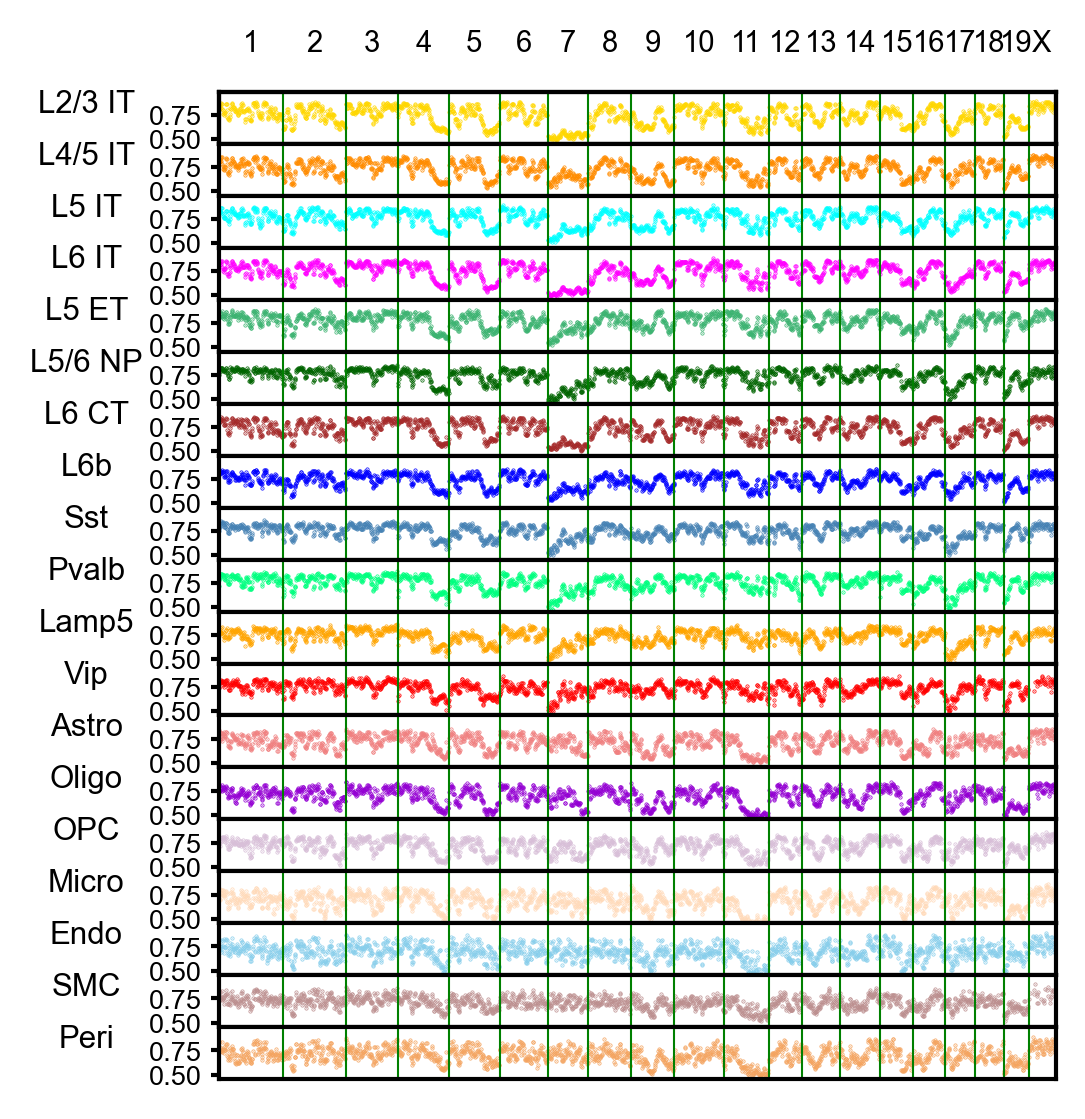

In [36]:
%matplotlib inline
#plt.style.use('default')
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

# min num of cells to include for plot
min_cell_th = 50
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','SMC','Peri', 
                           #'other',
                          ]

fig, ax = plt.subplots(figsize=(_single_col_width*1.6, _single_col_width*len(selected_cell_labels)/10), dpi=300)
grid = plt.GridSpec(len(selected_cell_labels), 1,  hspace=0., wspace=0.)
#colors = [celltype_palette[_c] for _c in selected_cell_labels]

import tqdm

#for _class, _summary_dict in result_dict.items():
for _class_ind, _class in tqdm.tqdm(enumerate(selected_cell_labels)):

    sorted_median_radial_pos = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_class]
    sorted_median_radial_pos.loc[sorted_median_radial_pos['total_cell']<min_cell_th,'norm_radial_position']=np.nan
    
    
    plot_chr_names = [str(i) for i in range(1,20)]
    plot_chr_names.append('X')
    plot_chr_edges = [len(sorted_median_radial_pos[sorted_median_radial_pos['chr']==chr_name]) for chr_name in plot_chr_names]

        
    x= np.arange(0, len(sorted_median_radial_pos))
    y= np.array(sorted_median_radial_pos['norm_radial_position'].tolist())
    
    plot_chr_edges=np.cumsum(plot_chr_edges)
    plot_chr_edges=np.insert(plot_chr_edges,0,0)
    
    ax = plt.subplot(grid[_class_ind])

    ax.scatter(x,y, alpha=0.9, s=0.15,marker ='.', color=celltype_palette[_class], rasterized=True)
    
    # add chr annotation as twiny dummy ax on top
    if _class_ind==0:
        ax2 = ax.twiny()
        ax2.set_xlim([0,plot_chr_edges[-1]])
        #ax2.set_xlim(ax.get_xlim())
        ax2_Labels = plot_chr_names
        ax2_tick_chr_edges = ((plot_chr_edges[1:]+plot_chr_edges[:-1])/2)
        ax2.set_xticks(ax2_tick_chr_edges,pad=5)
        ax2.set_xticklabels(ax2_Labels,fontdict={'fontsize':_font_size})
        ax2.tick_params(axis='x',          # changes apply to the x-axis
                         which='both',      # both major and minor ticks are affected
                          bottom=False,      # ticks along the bottom edge are off
                            top=False,         # ticks along the top edge are off
                            labelbottom=False,
                        labelsize=_font_size-0.5,
                       )
        ax2.set_ylabel("Chr", fontsize=_font_size, rotation=0,labelpad=5)
        ax2.grid(False)
       
    ax.tick_params('y',labelsize=_font_size-1,pad=2, length =2) # change y tick label size
    #ax.set_xlabel("Imaged loci", fontsize=12, labelpad=7, )
    ax.set_ylabel(f"{_class}", fontsize=_font_size, rotation=0,labelpad=15,loc="center")

    #ax.set_title(f"Radial positioning for loci in {_class}", fontsize=13, y=1)
    #if _class_ind +1 <=len(selected_cell_labels):
    ax.tick_params('x', labelrotation=45,
            pad=1,labelbottom=False, size=0)

    ymin = 0.45
    ymax= 0.99
    ax.set_ylim([ymin,ymax])
    #ax.set_yticks([-12,12])
    #ax.set_xlim([0,3050])
    ax.set_xlim([0,plot_chr_edges[-1]])

    ax.vlines(plot_chr_edges, ymin,ymax, color='green', linewidth=0.5)
    ax.grid(False)

plt.savefig(os.path.join(output_figure_folder, f'Radial_position_across_celltypes.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')
plt.show()

## correlation summary

meta NOT subset; don't know how to subset; dropped


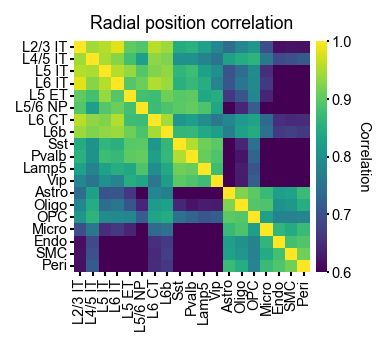

In [11]:
%matplotlib inline

from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.spatial.distance import cdist,pdist,squareform


corr_by_log10= False


# get all chromosome combined corr matrix

all_chr_combined_corr_mat = np.zeros((len(selected_cell_labels),len(selected_cell_labels)))

for _i, _class1 in enumerate(selected_cell_labels):
    sorted_median_radial_pos_cls1 = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_class1]
    sorted_median_radial_pos_cls1.loc[sorted_median_radial_pos_cls1['total_cell']<min_cell_th,'norm_radial_position']=np.nan
    
    for _j, _class2 in enumerate(selected_cell_labels):
        sorted_median_radial_pos_cls2 = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_class2]
        sorted_median_radial_pos_cls2.loc[sorted_median_radial_pos_cls2['total_cell']<min_cell_th,'norm_radial_position']=np.nan
        
        _radial_pos_1 = sorted_median_radial_pos_cls1['norm_radial_position'].tolist()
        _radial_pos_2 = sorted_median_radial_pos_cls2['norm_radial_position'].tolist()
        
        _radial_pos_1_valid_ind = ~np.isnan(_radial_pos_1)
        _radial_pos_2_valid_ind = ~np.isnan(_radial_pos_2)
        good_ind = _radial_pos_1_valid_ind * _radial_pos_2_valid_ind
        _radial_pos_1_good = np.array(_radial_pos_1)[good_ind]
        _radial_pos_2_good = np.array(_radial_pos_2)[good_ind]

        # calculate and append log correlation
        #spearr = stats.spearmanr()
        if len(_radial_pos_1_good)>0 and len(_radial_pos_2_good)>0:
            if corr_by_log10:
                lr = linregress(np.log(_radial_pos_1_good),
                    np.log(_radial_pos_2_good))
            else:
                lr = linregress((_radial_pos_1_good),
                    (_radial_pos_2_good))
            #contact_corr_for_class[_chr_index][_class]=lr.rvalue
            all_chr_combined_corr_mat[_i,_j]= lr.rvalue
        else:
            all_chr_combined_corr_mat[_i,_j]= np.nan


fig, ax = plt.subplots(figsize=(_page_width/2.25,_page_width/2.75),
                       dpi=150)

corr_matrix_df = pd.DataFrame(all_chr_combined_corr_mat, 
                             columns = selected_cell_labels, 
                             index = selected_cell_labels)
#ax.imshow(all_chr_combined_corr_mat, vmin=0.6,vmax=1,cmap='seismic')
sns.heatmap(corr_matrix_df, annot=False,
            cmap='viridis',ax=ax,vmin=0.6,vmax=1,
            cbar_kws={'label':'Correlation', "pad": 0.02}
           )

#ax.set_title(f"Correlation of radial positioning across cell types.", fontsize=15,  #y=0.98 pad=15
            #)
ax.set_xticks(np.arange(0,len(selected_cell_labels))+0.5)
ax.set_yticks(np.arange(0,len(selected_cell_labels))+0.5)
TickLabels = selected_cell_labels
ax.set_xticklabels(TickLabels,rotation=90,fontdict={'fontsize':_font_size})
ax.set_yticklabels(TickLabels,rotation=0,fontdict={'fontsize':_font_size})

ax.tick_params('x', labelsize=_font_size-0.5, 
                #width=_ticklabel_width, 
               length=_ticklabel_size,
                labeltop=False,
                pad=1, )
ax.tick_params('y', labelsize=_font_size-0.5, 
                #width=_ticklabel_width, 
               length=_ticklabel_size,
                #labeltop=False,
                pad=1, )
ax.figure.axes[-1].tick_params(axis='y', length=1, pad=1, labelsize=_font_size-0.5,)
ax.figure.axes[-1].set_ylabel('Correlation', fontsize=_font_size-0.5, rotation=270, labelpad=9)

ax.set_title('Radial position correlation')
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='6%', pad="2%")
#cb = plt.colorbar(ax.imshow(all_chr_combined_corr_mat, vmin=0.6,vmax=1,cmap='seismic'), cax=cax, orientation='vertical', 
                      #extend='neither', 
                      #)

plt.savefig(os.path.join(output_figure_folder, f'Corr_Radial_position_across_celltypes.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')
        
#cb.ax.minorticks_off()
plt.show()  


    
    